# Computer Vision Project

### Setup

In [1]:
import os                           # type: ignore
import numpy as np                  # type: ignore
import matplotlib.pyplot as plt     # type: ignore
import pandas as pd                 # type: ignore
import albumentations as albu       # type: ignore
import importlib
import segmentation
import segmentation.dataset
import segmentation.utils
importlib.reload(segmentation.dataset)

from segmentation.dataset import CVDataset
importlib.reload(segmentation.dataset)
importlib.reload(segmentation.utils)
from segmentation.utils import preprocessing, show, model_utils, ModelEval


from models import unet_model

/opt/miniconda3/envs/cv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
importlib.reload(segmentation.utils)

<module 'segmentation.utils' from '/Users/georgeboutselis/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Year 4/Semester 2/Computer Vision/Computer-Vision-Project/segmentation/utils.py'>

In [ ]:
# Defining some constants that will be used throughout the notebook
DATA_DIR = 'Dataset/'
x_test_dir = os.path.join(DATA_DIR, 'Test/color')
y_test_dir = os.path.join(DATA_DIR, 'Test/label')
x_trainVal_dir = os.path.join(DATA_DIR, 'TrainVal/color')
y_trainVal_dir = os.path.join(DATA_DIR, 'TrainVal/label')

### Splitting the TrainVal data into training and validation data
* Splitting into training and validations sets is needed so we can evaluate peformance on the model while training.
* More common than K-fold cross validation in deep learning settings because of computational costs.

In [6]:
# Getting a list of relative paths to the images (x) and the masks/labels (y)
x_test_fps, y_test_fps = preprocessing.get_testing_paths(x_test_dir, y_test_dir)

# Splitting relative path names into into training and validation
x_train_fps, x_val_fps, y_train_fps, y_val_fps = preprocessing.train_val_split(x_trainVal_dir, y_trainVal_dir, 0.2)


### Custom Dataset

In [173]:
test_augmentation = preprocessing.get_validation_augmentation()
preprocessing_fn = preprocessing.get_preprocessing()
train_augmentation = preprocessing.get_training_augmentation()

train_dataset = CVDataset(x_train_fps, y_train_fps, augmentation=train_augmentation)
valid_dataset = CVDataset(x_val_fps, y_val_fps)

test_dataset  = CVDataset(
                x_test_fps[:10],
                y_test_fps[:10],
                augmentation = test_augmentation,
                preprocessing=preprocessing_fn
                )


# Printing the size of each dataset
print(f'Training dataset has size {train_dataset.__len__()}')
print(f'Validation dataset has size {valid_dataset.__len__()}')
print(f'Testing dataset has size {test_dataset.__len__()}')

Training dataset has size 2938
Validation dataset has size 735
Testing dataset has size 10


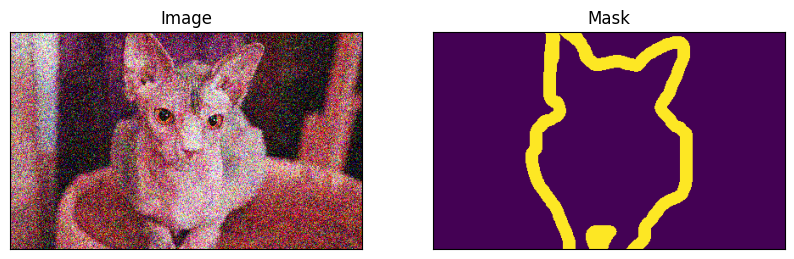

In [174]:
image, mask = train_dataset[1]
show.visualiseData(image = image, mask = mask)

In [6]:
import segmentation.utils
importlib.reload(segmentation.utils)
from segmentation.utils import model_utils

## Saving the model

In [7]:
# 0. Create your model and train it
model = unet_model.UNET(in_channels=3, out_channels=3)
# train function/code or whatever you need to use

# 1. get the state dict for the model (weights etc)
#    This is a built in method if model inherits from nn.Module
state_dict = model.state_dict()

# 2. Create a checkpoint
checkpoint = {'state_dict': state_dict, # 'state_dict' key name must be named state_dict exactly
              'epochs':10,              # Add optional additional elements to the checkpoint for experiment tracking
              'learning_rate': 10}      # these can be named whatever you like, and there can be as many as you like

# 3. save the checkpoint to your computer/google colab files
model_utils.save_checkpoint(
    checkpoint,
    'test.pth'  # Where you want to save & filename, if you want to save to folder called 'checkpoints' for instance, just change to 'checkpoints/test.pth'
    )

=> Final model and metadata saved to test.pth


## Loading the model 

In [29]:
import segmentation.utils
importlib.reload(segmentation.utils)
from segmentation.utils import ModelEval

In [30]:
# 1. Create an instance of the model (you do not have to retrain now)
loaded_model = unet_model.UNET(in_channels=3, out_channels=3) # Creating another instance of the model

# 2. Load the saved model weights from the test.pth file
model_utils.load_checkpoint('test.pth', loaded_model)

# 3. Now you have your trained model loaded in to loaded model

## ALTERNATIVELY if you want to evaluate the model directly you can do this

# 1. Create the ModelEval object
eval = ModelEval(test_dataset, loaded_model, device = 'cpu')
eval.load_model('test.pth') # this loads the trained model weights into the loaded model you passed into ModelEval
image, mask = eval.predict(1) # generate predicted mask image 1 from your trained model (automatically on the original scale of the image)


=> Loading checkpoint from test.pth
=> Loading model from test.pth
=> Model successfully loaded!
torch.Size([1, 3, 256, 416])


In [26]:
mask.shape

torch.Size([383, 400])

In [27]:
model_eval = ModelEval(test)

NameError: name 'test' is not defined

In [7]:
model = unet_model.UNET(in_channels=3, out_channels=3)

In [44]:

model_utils.load_checkpoint('train_unet.py', model)

=> Loading checkpoint


TypeError: string indices must be integers, not 'str'

In [45]:
eval = ModelEval(test_dataset, model, device = 'cpu')

In [46]:
eval.load_model('test.pth')

=> Loading model from test.pth
=> Model successfully loaded!


/Users/georgeboutselis/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Year 4/Semester 2/Computer Vision/Computer-Vision-Project/segmentation/utils.py:459: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related

In [60]:
from segmentation.utils import traininglog
traininglog.log_training('test', IoU = 0.5,jjwfwfjw = 2)

In [9]:
eval.load_model('s3://computer-vision-state-dictionaries/unet_experiment_1/unet_best_model_trial_0.pth')

=> Downloading model from s3://computer-vision-state-dictionaries/unet_experiment_1/unet_best_model_trial_0.pth...
=> Model downloaded from S3 to temp_model.pth
=> Loading model from temp_model.pth
=> Model successfully loaded!


/Users/georgeboutselis/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Year 4/Semester 2/Computer Vision/Computer-Vision-Project/segmentation/utils.py:459: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related

In [50]:
eval.mean_IoU(progress_bar=True)

100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


0.5257847309112549

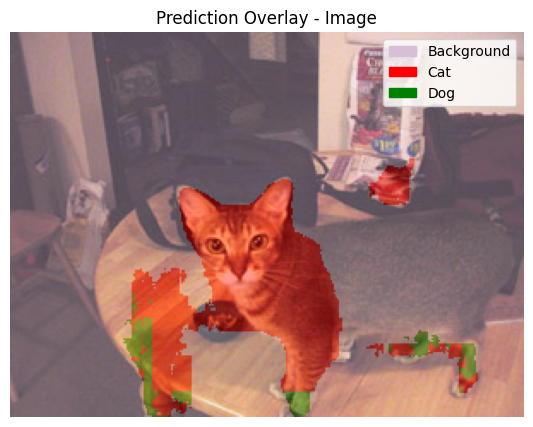

In [49]:
eval.plot_prediction_overlay(2, alpha=0.4)

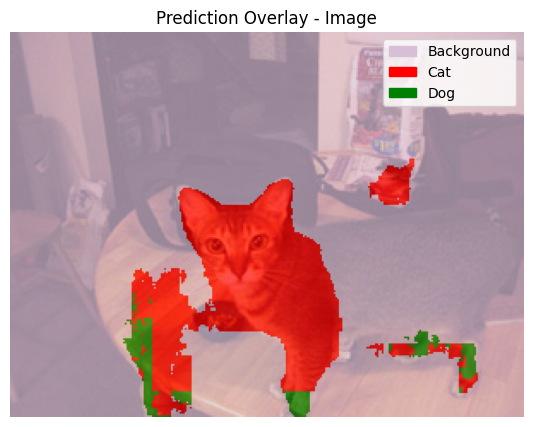

IoU on original domain: 0.3889


In [18]:
eval.image_fit_summary(2, alpha = 0.7)

## Point based segmentation

In [200]:
import segmentation.dataset
importlib.reload(segmentation.dataset)
from segmentation.dataset import CVDataset
import segmentation.utils
importlib.reload(segmentation.utils)
from segmentation.utils import show

In [201]:
train_aumentation = preprocessing.get_training_augmentation()
preprocessing_fn = preprocessing.get_preprocessing()
train_dataset = CVDataset(x_train_fps, y_train_fps, augmentation=train_aumentation)